In [1]:
#import Pkg; Pkg.add("StatsPlots")
#import Pkg; Pkg.add("GLMNet")
#import Pkg; Pkg.add("ScikitLearn")
#import Pkg; Pkg.add("MLJLinearModels")
using StatsPlots
using GLMNet  # Asegúrate de cargar GLMNet
using CSV
using DataFrames
using Plots
using Statistics
using MLJ
using ScikitLearn
using MLJLinearModels
using DecisionTree

In [2]:
# Carga los datos
df = CSV.read("Smarket.csv", DataFrame);

In [3]:
# --- count_missing(col) ---
function count_missing(col::AbstractVector)
    return sum(ismissing.(col))
end

# --- dataMissingPercentage ---
function dataMissingPercentage(df::DataFrame)
    """Calcula el porcentaje de datos faltantes en cada columna del DataFrame.

    Args:
      df: El DataFrame a inspeccionar.

    Returns:
      Un diccionario donde las claves son los nombres de las columnas y los 
      valores son los porcentajes de datos faltantes.
    """
    missing_percentages = Dict{String, Float64}()
    for col_name in names(df)
        missing_count = count_missing(df[:, col_name])
        missing_percentages[col_name] = (missing_count / nrow(df)) * 100
    end
    return missing_percentages
end

# Imprimir el número de valores faltantes en cada columna
println("\nNúmero de valores faltantes en cada columna:")
for (col_name, missing_count) in dataMissingPercentage(df)
    println("$col_name: $missing_count %")
end


Número de valores faltantes en cada columna:
Lag1: 0.0 %
Lag3: 0.0 %
Today: 0.0 %
Lag5: 0.0 %
Lag4: 0.0 %
Volume: 0.0 %
Lag2: 0.0 %
Year: 0.0 %
Direction: 0.0 %


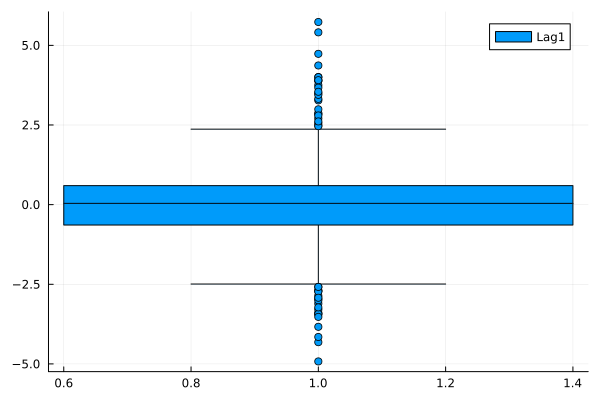

In [4]:
# Ejemplo con la variable 'Lag1'
boxplot(df.Lag1, label="Lag1") 

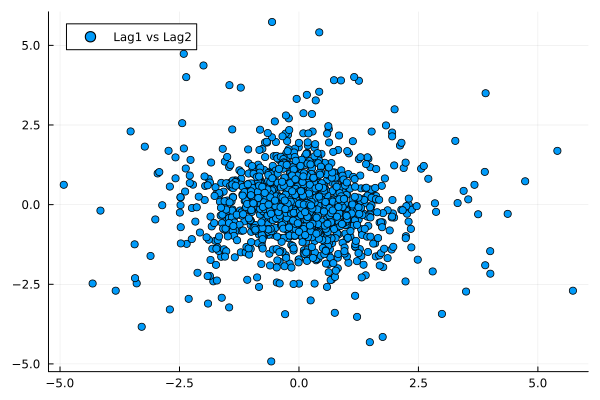

In [5]:
scatter(df.Lag1, df.Lag2, label="Lag1 vs Lag2")

In [6]:
# --- Verificar si hay outliers en todas las columnas al mismo tiempo ---

function allColumnsOutliers(df)
    """
    Verifica si hay outliers en todas las columnas numéricas al mismo tiempo.

    Args:
      df: DataFrame.

    Returns:
      DataFrame con las filas que son outliers en todas las columnas.
    """
    df_outliers_all_cols = copy(df)
    for col in names(df, findall(x -> eltype(x) <: Number, eachcol(df)))
        q1 = quantile(df[:, col], 0.25)
        q3 = quantile(df[:, col], 0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df_outliers_all_cols = filter(row -> row[col] < lower_bound || row[col] > upper_bound, df_outliers_all_cols)
    end
    return df_outliers_all_cols
end

df_outliers_all_cols = allColumnsOutliers(df)

if nrow(df_outliers_all_cols) > 0
    println("Hay filas con outliers en todas las columnas:")
    println(df_outliers_all_cols)
else
    println("No hay filas con outliers en todas las columnas.")
end



No hay filas con outliers en todas las columnas.


In [7]:
boxplot(df_sin_outliers.Lag1, label="Lag1") 

LoadError: UndefVarError: `df_sin_outliers` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [8]:
scatter(df_sin_outliers.Lag1, df.Lag2, label="Lag1 vs Lag2")

LoadError: UndefVarError: `df_sin_outliers` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [9]:
# Convertir 'Direction' a una matriz numérica
y = ifelse.(df.Direction .== "Up", 1, 0)  # Transformar a 1 y 0

# Seleccionar las variables predictoras
X = df[:, [:Lag1, :Lag2, :Lag3, :Lag4, :Lag5, :Volume]]

1250×6 DataFrame
  Row │ Lag1     Lag2     Lag3     Lag4     Lag5     Volume  
      │ Float64  Float64  Float64  Float64  Float64  Float64 
──────┼──────────────────────────────────────────────────────
    1 │   0.381   -0.192   -2.624   -1.055    5.01   1.1913
    2 │   0.959    0.381   -0.192   -2.624   -1.055  1.2965
    3 │   1.032    0.959    0.381   -0.192   -2.624  1.4112
    4 │  -0.623    1.032    0.959    0.381   -0.192  1.276
    5 │   0.614   -0.623    1.032    0.959    0.381  1.2057
    6 │   0.213    0.614   -0.623    1.032    0.959  1.3491
    7 │   1.392    0.213    0.614   -0.623    1.032  1.445
    8 │  -0.403    1.392    0.213    0.614   -0.623  1.4078
    9 │   0.027   -0.403    1.392    0.213    0.614  1.164
   10 │   1.303    0.027   -0.403    1.392    0.213  1.2326
   11 │   0.287    1.303    0.027   -0.403    1.392  1.309
  ⋮   │    ⋮        ⋮        ⋮        ⋮        ⋮        ⋮
 1241 │  -0.141    0.419    0.555    0.084    0.281  2.18059
 1242 │  -0.285   -0.141    0.419    0.555    0.084  2.58419
 1243 │  -0.584   -0.285   -0.141    0.419    0.555  2.20881
 1244 │  -0.024   -0.584   -0.285   -0.141    0.419  1.99669
 1245 │   0.252   -0.024   -0.584   -0.285   -0.141  2.06517
 1246 │   0.422    0.252   -0.024   -0.584   -0.285  1.8885
 1247 │   0.043    0.422    0.252   -0.024   -0.584  1.28581
 1248 │  -0.955    0.043    0.422    0.252   -0.024  1.54047
 1249 │   0.13    -0.955    0.043    0.422    0.252  1.42236
 1250 │  -0.298    0.13    -0.955    0.043    0.422  1.38254
                                            1229 rows omitted

In [146]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_indices, test_indices = partition(eachindex(y), 0.7, shuffle = true, rng = 123)

train_X = X[train_indices, :]
test_X = X[test_indices, :]
train_y = y[train_indices]
test_y = y[test_indices]

375-element PooledArrays.PooledVector{String7, UInt32, Vector{UInt32}}:
 "Down"
 "Down"
 "Down"
 "Up"
 "Up"
 "Up"
 "Down"
 "Up"
 "Up"
 "Down"
 "Up"
 "Down"
 "Down"
 ⋮
 "Down"
 "Up"
 "Up"
 "Down"
 "Up"
 "Down"
 "Down"
 "Down"
 "Up"
 "Down"
 "Up"
 "Up"

In [11]:
using MLJ: fit!

# Cargar el modelo LASSO
LassoRegressor = @load LassoRegressor pkg=MLJLinearModels

# Crear una instancia del modelo con un valor de lambda
model = LassoRegressor(lambda = 0.1)

# Entrenar el modelo
mach = machine(model, train_X, float.(train_y))
fitresult = fit!(mach)

[ Info: For silent loading, specify `verbosity=0`. 


import MLJLinearModels ✔


[ Info: Training machine(LassoRegressor(lambda = 0.1, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false


trained Machine; caches model-specific representations of data
  model: LassoRegressor(lambda = 0.1, …)
  args: 
    1:	Source @788 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @597 ⏎ AbstractVector{Continuous}


In [12]:
using MLJ: predict, accuracy

# Hacer predicciones en el conjunto de prueba
y_pred = predict(mach, test_X)

# Calcular la precisión
acc = accuracy(y_pred, test_y)
println("Precisión (Accuracy): ", acc)

Precisión (Accuracy): 0.0


In [13]:
# Definir un rango de valores para lambda
lambdas = 10.0 .^ range(-5, stop = 0, length = 20)

# Crear un vector para almacenar las precisiones
accuracies = Float64[]

# Iterar sobre los valores de lambda
for lambda in lambdas
    # Crear una instancia del modelo con el valor actual de lambda
    model = LassoRegressor(lambda = lambda)

    # Entrenar el modelo
    mach = machine(model, train_X, float.(train_y))
    fit!(mach)

    # Hacer predicciones en el conjunto de prueba
    y_pred = predict(mach, test_X)

    # Calcular la precisión y almacenarla en el vector accuracies
    acc = accuracy(y_pred, test_y)
    push!(accuracies, acc)
end

# Encontrar el mejor valor de lambda (que maximiza la precisión)
best_lambda = lambdas[argmax(accuracies)]
println("Mejor valor de lambda: ", best_lambda)

[ Info: Training machine(LassoRegressor(lambda = 1.0e-5, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false
[ Info: Training machine(LassoRegressor(lambda = 1.8329807108324375e-5, …), …).


Mejor valor de lambda: 1.0e-5


┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false
[ Info: Training machine(LassoRegressor(lambda = 3.359818286283781e-5, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false
[ Info: Training machine(LassoRegressor(lambda = 6.158482110660267e-5, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false
[ Info: Training machine(LassoRegressor(lambda = 0.00011288378916846895, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false
[ Info: Training machine(LassoRegressor(lambda = 0.00020691380811147902, …), …).
┌ Info: Solver: ProxGrad
│  

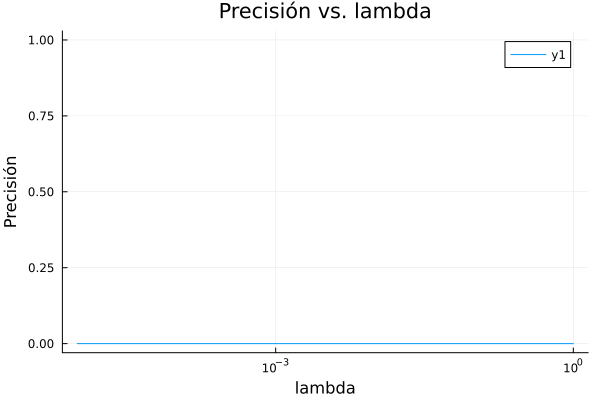

In [14]:
# Graficar la precisión en función de lambda
plot(lambdas, accuracies, xscale = :log10, xlabel = "lambda", ylabel = "Precisión", title = "Precisión vs. lambda")

In [15]:
using MLJ: fit!

# Cargar el modelo LASSO
LassoRegressor = @load LassoRegressor pkg=MLJLinearModels

# Crear una instancia del modelo con un valor de lambda
model = LassoRegressor(lambda = best_lambda)

# Entrenar el modelo
mach = machine(model, train_X, float.(train_y))
fitresult = fit!(mach)

import MLJLinearModels ✔


[ Info: For silent loading, specify `verbosity=0`. 
[ Info: Training machine(LassoRegressor(lambda = 1.0e-5, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false


trained Machine; caches model-specific representations of data
  model: LassoRegressor(lambda = 1.0e-5, …)
  args: 
    1:	Source @983 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @907 ⏎ AbstractVector{Continuous}


In [16]:
using MLJ: predict, accuracy

# Hacer predicciones en el conjunto de prueba
y_pred = predict(mach, test_X)

# Calcular la precisión
acc = accuracy(y_pred, test_y)
println("Precisión (Accuracy): ", acc)

Precisión (Accuracy): 0.0


In [17]:
using MLJ: predict_mode

# Obtener las predicciones como etiquetas de clase
y_pred_class = predict_mode(mach, test_X)

# Definir un umbral de decisión
threshold = 0.01

# Convertir las predicciones a 1 o 0 según el umbral
y_pred_binary = ifelse.(y_pred_class .== "Up", 1, 0)

# Calcular la precisión con el umbral definido
acc = accuracy(y_pred_binary, test_y)
println("Precisión con umbral de $threshold: ", acc)

Precisión con umbral de 0.01: 0.49333333333333335


In [18]:
using MLJ: confusion_matrix

# Convertir las predicciones a etiquetas de clase (0 o 1)
y_pred_class = ifelse.(y_pred .>= 0.5, 1, 0)

# Calcular la matriz de confusión
cm = confusion_matrix(y_pred_class, test_y)

# Mostrar la matriz de confusión
println("Matriz de Confusión:")
display(cm)

Matriz de Confusión:


          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │  13  │  14  │
├─────────┼──────┼──────┤
│    1    │ 172  │ 176  │
└─────────┴──────┴──────┘


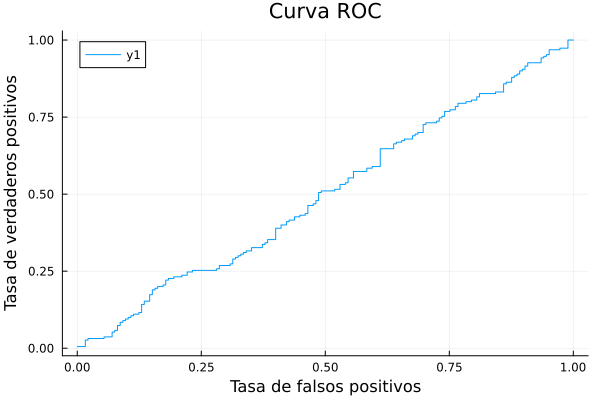

In [19]:
# Ordenar las predicciones en orden descendente
sorted_indices = sortperm(y_pred, rev=true)
sorted_y_pred = y_pred[sorted_indices]
sorted_test_y = test_y[sorted_indices]

# Inicializar vectores para almacenar las TPR y FPR
tpr_values = Float64[]
fpr_values = Float64[]

# Calcular el número de positivos y negativos reales
n_positives = sum(sorted_test_y)
n_negatives = length(sorted_test_y) - n_positives

# Iterar sobre las predicciones ordenadas
for i in 1:length(sorted_y_pred)
    # Calcular el número de verdaderos positivos, falsos positivos, etc.
    tp = sum(sorted_test_y[1:i])
    fp = i - tp
    
    # Calcular la TPR y la FPR
    tpr = tp / n_positives
    fpr = fp / n_negatives
    
    # Almacenar las TPR y FPR
    push!(tpr_values, tpr)
    push!(fpr_values, fpr)
end

# Graficar la curva ROC
plot(fpr_values, tpr_values, xlabel="Tasa de falsos positivos", ylabel="Tasa de verdaderos positivos", title="Curva ROC")


# Agregar la línea diagonal
plot!([0, 1], [0, 1], linestyle=:dash, label="Clasificador aleatorio")

# Mostrar el gráfico
display(plot(fpr_values, tpr_values, xlabel="Tasa de falsos positivos", ylabel="Tasa de verdaderos positivos", title="Curva ROC"))

In [27]:
using MultivariateStats

# ... (código para preparar los datos X e y, y dividirlos en train_X, test_X, train_y, test_y)

# Convertir X a una matriz
X = Matrix(X)

# Convertir y a Float64
y = float.(y)

# Entrenar un modelo Ridge inicial con un valor de lambda arbitrario (por ejemplo, 0.1)
lambda_inicial = 0.1
model_ridge_inicial = ridge(X, y, lambda_inicial)  

# Imprimir los coeficientes del modelo inicial (no necesitas coef() aquí)
println("Coeficientes del modelo inicial: ", model_ridge_inicial)

Coeficientes del modelo inicial: [-0.018148824267584227, -0.010501021768254522, 0.0027742715872277014, 0.002334291825371787, 0.0025697157805852715, 0.033623701583244424, 0.4687816646581549]


In [39]:
# Ajustar el modelo Ridge con diferentes valores de lambda
lambdas = 10.0 .^ range(-5, stop=0, length=20)
accuracies = Float64[]

for lambda in lambdas
    # Ajustar el modelo Ridge
    coefs_ridge = ridge(Matrix(train_X), float.(train_y), lambda)  # Obtener los coeficientes

    # Eliminar el intercepto de los coeficientes (dentro del ciclo)
    coefs_ridge = coefs_ridge[2:end] 

    # Calcular las predicciones manualmente
    intercept = mean(train_y)
    y_pred = Matrix(test_X) * coefs_ridge .+ intercept

    y_pred_class = ifelse.(y_pred .>= 0.5, 1, 0)
    acc = accuracy(y_pred_class, test_y)
    push!(accuracies, acc)
end

# Encontrar el mejor valor de lambda
best_lambda = lambdas[argmax(accuracies)]
println("Mejor valor de lambda: ", best_lambda)

Mejor valor de lambda: 1.0e-5


In [40]:
# Ajustar el modelo final con el mejor lambda
best_model_ridge = ridge(X, y, best_lambda)

7-element Vector{Float64}:
 -0.01815022414114991
 -0.010501402836826526
  0.002774713429409272
  0.0023347686949486005
  0.0025700290213373236
  0.03364471210526017
  0.4687506082640503

In [47]:
# Obtener los coeficientes del modelo final
coefs_ridge = best_model_ridge  # Obtener los coeficientes

# Eliminar el intercepto de los coeficientes
coefs_ridge = coefs_ridge[2:end]

# Calcular las predicciones manualmente
intercept = mean(y)  # Calcular el intercepto (promedio de y)
y_pred = Matrix(test_X) * coefs_ridge .+ intercept  # Calcular y_pred

# Convertir las predicciones a etiquetas de clase (0 o 1)
y_pred_class = ifelse.(y_pred .>= 0.5, 1, 0)

# Matriz de confusión
using MLJ: confusion_matrix
cm = confusion_matrix(y_pred_class, test_y)
println("Matriz de Confusión:")
display(cm)

Matriz de Confusión:


          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │  0   │  0   │
├─────────┼──────┼──────┤
│    1    │ 185  │ 190  │
└─────────┴──────┴──────┘


In [50]:
# Calcular la precisión del modelo final
coefs_ridge = best_model_ridge  # Obtener los coeficientes del modelo final

# Eliminar el intercepto de los coeficientes
coefs_ridge = coefs_ridge[2:end]

# Calcular las predicciones manualmente
intercept = mean(y)
y_pred_final = Matrix(test_X) * coefs_ridge .+ intercept

# Ajustar el threshold
threshold = 0.4  # Puedes cambiar este valor

# Convertir las predicciones a etiquetas de clase (0 o 1) usando el threshold
y_pred_class_final = ifelse.(y_pred_final .>= threshold, 1, 0)

# Calcular la precisión
accuracy_final = accuracy(y_pred_class_final, test_y)

println("Precisión del modelo Ridge con threshold de $threshold: ", accuracy_final)

Precisión del modelo Ridge con threshold de 0.4: 0.5066666666666667


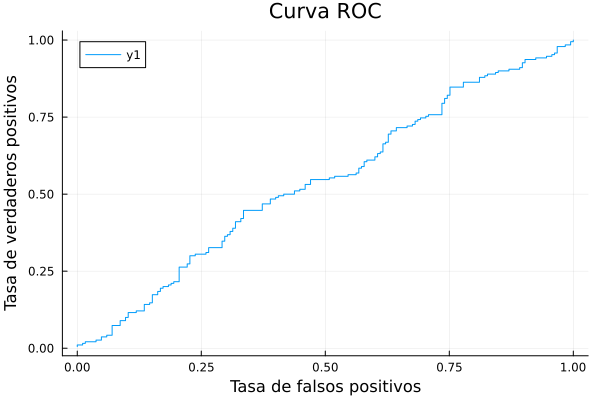

In [51]:
using Plots

# Ordenar las predicciones en orden descendente
sorted_indices = sortperm(y_pred_final, rev=true)
sorted_y_pred = y_pred_final[sorted_indices]
sorted_test_y = test_y[sorted_indices]

# Inicializar vectores para almacenar las TPR y FPR
tpr_values = Float64[]
fpr_values = Float64[]

# Calcular el número de positivos y negativos reales
n_positives = sum(sorted_test_y)
n_negatives = length(sorted_test_y) - n_positives

# Iterar sobre las predicciones ordenadas
for i in 1:length(sorted_y_pred)
    # Calcular el número de verdaderos positivos, falsos positivos, etc.
    tp = sum(sorted_test_y[1:i])
    fp = i - tp
    
    # Calcular la TPR y la FPR
    tpr = tp / n_positives
    fpr = fp / n_negatives
    
    # Almacenar las TPR y FPR
    push!(tpr_values, tpr)
    push!(fpr_values, fpr)
end

# Graficar la curva ROC
plot(fpr_values, tpr_values, xlabel="Tasa de falsos positivos", ylabel="Tasa de verdaderos positivos", title="Curva ROC")

# Agregar la línea diagonal
plot!([0, 1], [0, 1], linestyle=:dash, label="Clasificador aleatorio")

# Mostrar el gráfico
display(plot(fpr_values, tpr_values, xlabel="Tasa de falsos positivos", ylabel="Tasa de verdaderos positivos", title="Curva ROC"))

In [87]:
using GLMNet

# Convertir las variables predictoras a matrices
train_X_matrix = Matrix(train_X)
test_X_matrix = Matrix(test_X)


375×6 Matrix{Float64}:
  0.454  -0.95    0.154   1.596   0.525  1.1606
 -1.736  -1.891   0.812  -0.218  -0.865  1.1122
 -0.645   0.75   -3.396  -2.472  -1.218  1.6074
  0.381  -0.192  -2.624  -1.055   5.01   1.1913
  0.887   0.101   0.002   0.028   0.055  2.17612
 -2.097   0.249  -0.344   2.145   1.941  1.5436
 -0.51    0.846  -0.38    1.504  -0.068  1.5319
 -0.771  -1.315  -0.814   2.352  -1.342  1.3859
 -0.151   0.466   1.002   0.696   1.009  1.63175
  1.763  -1.962   0.587  -2.584   1.483  1.1262
 -0.636   0.002  -0.851   0.209   0.347  2.37469
  0.0     1.939  -1.409  -0.654   2.247  1.4854
 -2.308  -2.957   0.979   0.425   5.408  1.5381
  ⋮                                      ⋮
 -0.021   0.125  -0.687   0.172   0.9    1.85137
  0.012   0.8     0.047  -0.243   0.652  1.0236
 -1.553  -0.263   1.615   0.269   0.272  1.1348
  0.103   0.986  -0.319   0.596  -0.6    2.22986
 -1.431  -0.766   1.749  -0.556  -0.195  1.2253
 -2.472  -1.218   3.673   0.622  -2.123  1.3489
 -0.992   1.003  

In [96]:
# Convertir las variables predictoras a matrices
train_X_matrix = Matrix(train_X)
test_X_matrix = Matrix(test_X)

# Crear el modelo Elastic Net
alpha = 0.5
lambda_values = 10.0 .^ range(-5, stop = 0, length = 20)

# Entrenar el modelo Elastic Net
elastic_net_model = glmnet(train_X_matrix, float.(train_y), alpha = alpha, lambda = lambda_values)

# Hacer predicciones en el conjunto de prueba
# Usar `predict` para obtener las predicciones
y_pred_elastic_net = GLMNet.predict(elastic_net_model, test_X_matrix)

# Seleccionar las predicciones correspondientes al mejor valor de lambda
best_lambda_index = argmax(lambda_values)
y_pred_elastic_net = y_pred_elastic_net[:, best_lambda_index]

# Convertir las predicciones a 0 y 1
y_pred_elastic_net = round.(Int, y_pred_elastic_net)

# Calcular la precisión
acc_elastic_net = accuracy(y_pred_elastic_net, test_y)
println("Precisión (Accuracy) Elastic Net: ", acc_elastic_net)


Precisión (Accuracy) Elastic Net: 0.5066666666666667


In [97]:
# Crear un vector para almacenar las precisiones
accuracies_elastic_net = Float64[]

# Iterar sobre los valores de lambda
for lambda in lambda_values
    # Crear y ajustar el modelo Elastic Net con el valor actual de lambda
    elastic_net_model = glmnet(train_X_matrix, float.(train_y), alpha = alpha, lambda = [lambda])
    y_pred = GLMNet.predict(elastic_net_model, test_X_matrix)
    y_pred = y_pred[:, 1]  # Seleccionar el conjunto de predicciones
    y_pred = round.(Int, y_pred)
    acc = accuracy(y_pred, test_y)
    push!(accuracies_elastic_net, acc)
end

# Encontrar el mejor valor de lambda
best_lambda_elastic_net = lambda_values[argmax(accuracies_elastic_net)]
println("Mejor valor de lambda para Elastic Net: ", best_lambda_elastic_net)


Mejor valor de lambda para Elastic Net: 0.000379269019073225


In [98]:
# Convertir las variables predictoras a matrices
train_X_matrix = Matrix(train_X)
test_X_matrix = Matrix(test_X)

# Mejor valor de lambda encontrado anteriormente
best_lambda_elastic_net = 1.0e-5  # Asegúrate de utilizar el valor real que obtuviste

# Crear y ajustar el modelo Elastic Net con el mejor valor de lambda
alpha = 0.5  # El mismo valor de alpha que utilizamos antes
elastic_net_model_best = glmnet(train_X_matrix, float.(train_y), alpha = alpha, lambda = [best_lambda_elastic_net])

# Hacer predicciones en el conjunto de prueba
y_pred_best_elastic_net = GLMNet.predict(elastic_net_model_best, test_X_matrix)
y_pred_best_elastic_net = y_pred_best_elastic_net[:, 1]  # Seleccionar el conjunto de predicciones

# Convertir las predicciones a 0 y 1
y_pred_best_elastic_net = round.(Int, y_pred_best_elastic_net)

# Calcular la precisión
acc_best_elastic_net = accuracy(y_pred_best_elastic_net, test_y)
println("Precisión (Accuracy) con Elastic Net utilizando la mejor lambda: ", acc_best_elastic_net)


Precisión (Accuracy) con Elastic Net utilizando la mejor lambda: 0.512


In [104]:
using MLJ
using MLJBase

# Matriz de confusión
conf_matrix = MLJ.confusion_matrix(test_y, y_pred_best_elastic_net)
println("Matriz de Confusión:")
println(conf_matrix)

# Precisión (Accuracy)
accuracy_final = MLJ.accuracy(test_y, y_pred_best_elastic_net)
println("Precisión (Accuracy): ", accuracy_final)


Matriz de Confusión:
ConfusionMatrix{2}([22 163; 20 170])
Precisión (Accuracy): 0.512


In [114]:
using Plots

# Función para calcular la curva ROC manualmente
function roc_curve_manual(y_true, y_scores)
    thresholds = sort(unique(y_scores), rev=true)
    tpr = Float64[]
    fpr = Float64[]

    for threshold in thresholds
        y_pred = y_scores .>= threshold
        tp = sum((y_pred .== 1) .& (y_true .== 1))
        fp = sum((y_pred .== 1) .& (y_true .== 0))
        fn = sum((y_pred .== 0) .& (y_true .== 1))
        tn = sum((y_pred .== 0) .& (y_true .== 0))
        
        push!(tpr, tp / (tp + fn))
        push!(fpr, fp / (fp + tn))
    end

    return fpr, tpr
end

# Calcular la curva ROC
fpr, tpr = roc_curve_manual(test_y, y_prob_best_elastic_net)

# Calcular el AUC manualmente
auc_score = sum((fpr[i+1] - fpr[i]) * (tpr[i] + tpr[i+1]) / 2 for i in 1:length(fpr)-1)
println("AUC: ", auc_score)


AUC: 0.5216216216216215


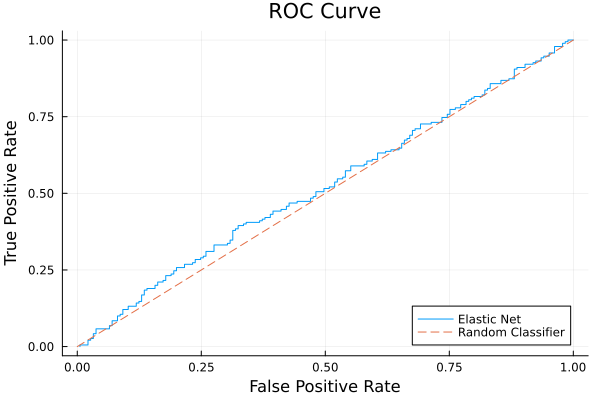

In [115]:
using Plots

# Graficar la curva ROC
plot(fpr, tpr, label="Elastic Net", xlabel="False Positive Rate", ylabel="True Positive Rate", title="ROC Curve", legend=:bottomright)
plot!([0, 1], [0, 1], linestyle=:dash, label="Random Classifier")  # Línea diagonal para referencia
